In [1]:
%%capture
%pip install statsforecast coreforecast -U

In [2]:
from statsforecast import StatsForecast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
url = 'https://docs.google.com/spreadsheets/d/1RycpkYhYqDKGuBmNtyPz6_-HM-jm7uPDjhsvZB-xcv0/export?format=csv'
df = pd.read_csv(url)
df.head()

,Month,Icecream
0,01/01/1995,51.595
1,01/02/1995,56.086
2,01/03/1995,68.453
3,01/04/1995,65.722
4,01/05/1995,73.730


In [10]:
df.shape

(216, 2)

In [12]:

from statsforecast import StatsForecast
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [26]:
df['ds'] = range(df.shape[0])
df['unique_id'] = 1
df['y']= df['Icecream']

In [54]:
df = df.drop( ['Month','Icecream'],axis = 1)

In [55]:
df.head()

,ds,unique_id,y
0,0,1,51.595
1,1,1,56.086
2,2,1,68.453
3,3,1,65.722
4,4,1,73.730


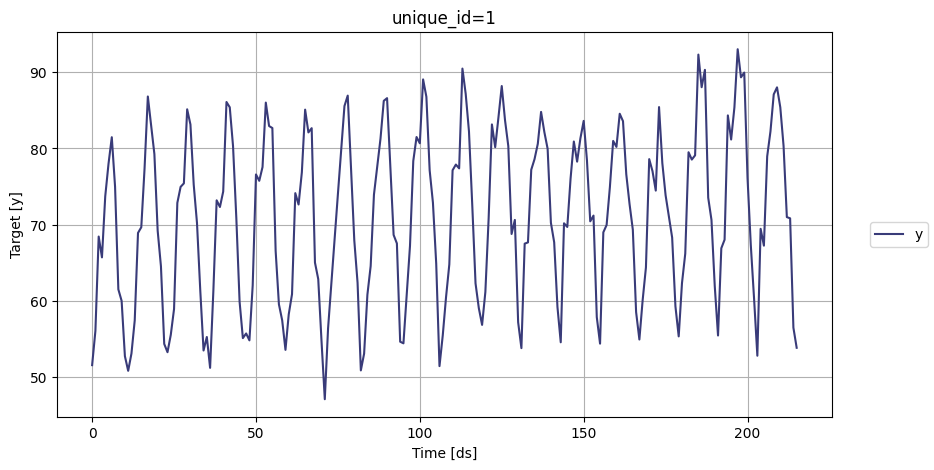

In [56]:
f = StatsForecast.plot(df)
f.set_figwidth(10)
f.set_figheight(5)
f

In [57]:
from coreforecast.seasonal import find_season_length
find_season_length(df.y.values, max_season_length=100)

12

In [58]:
from statsmodels.tsa.stattools import kpss
kpss(df.y)

(0.47367277254945445,
 0.04759622239877153,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [59]:
df.shape

(216, 3)

In [60]:
Y_train_df = df[df.ds<=203]
Y_test_df = df[df.ds>203]
Y_train_df.shape, Y_test_df.shape


((204, 3), (12, 3))

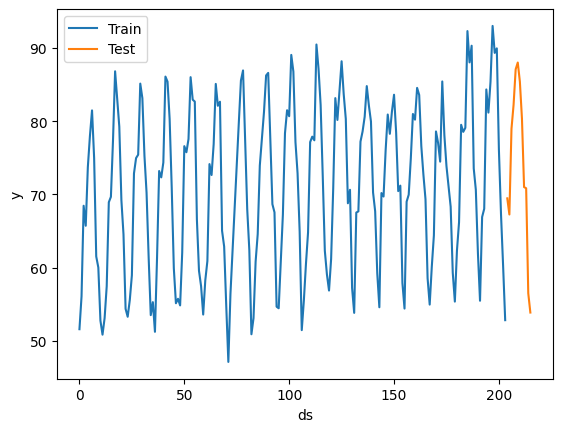

In [61]:
sns.lineplot(Y_train_df,x="ds", y="y", label="Train")
sns.lineplot(Y_test_df, x="ds", y="y", label="Test")
plt.show()

In [62]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string


In [63]:
season_length = 12
horizon = len(Y_test_df)

models = [AutoARIMA(season_length=season_length)]


In [64]:
sf = StatsForecast(df=Y_train_df,
                   models=models,
                   freq=1,
                   n_jobs=-1)


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


In [65]:
sf.fit()
sf.predict(h=12)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


,unique_id,ds,AutoARIMA
0,1,204,62.644821
1,1,205,68.254082
2,1,206,78.833382
3,1,207,80.054314
4,1,208,81.297157
5,1,209,89.614212
6,1,210,86.489677
7,1,211,84.950829
8,1,212,73.701309
9,1,213,67.777336


In [67]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual


dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(3, 2, 1, 1, 12, 0, 1)


,residual Model
0,0.051595
1,0.056086
2,0.068453
3,0.065722
4,0.073730
...,...
199,1.510366
200,2.307488
201,-5.827476
202,0.358873


<ipython-input-69-8cb6aedd7fe7>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual, ax=axs[0,1]);


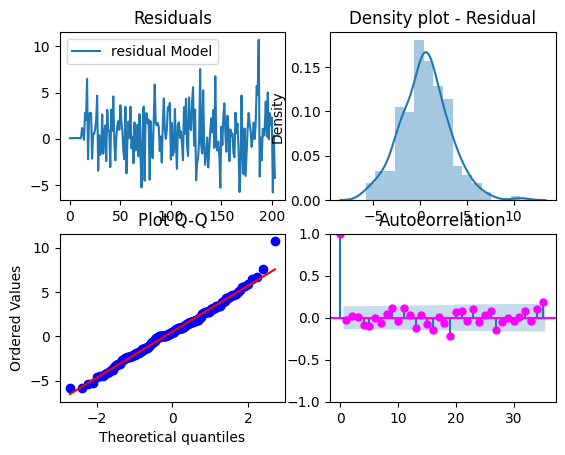

In [69]:
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();


In [70]:
Y_hat_df = sf.forecast(horizon, fitted=True)


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


In [71]:
values=sf.forecast_fitted_values()


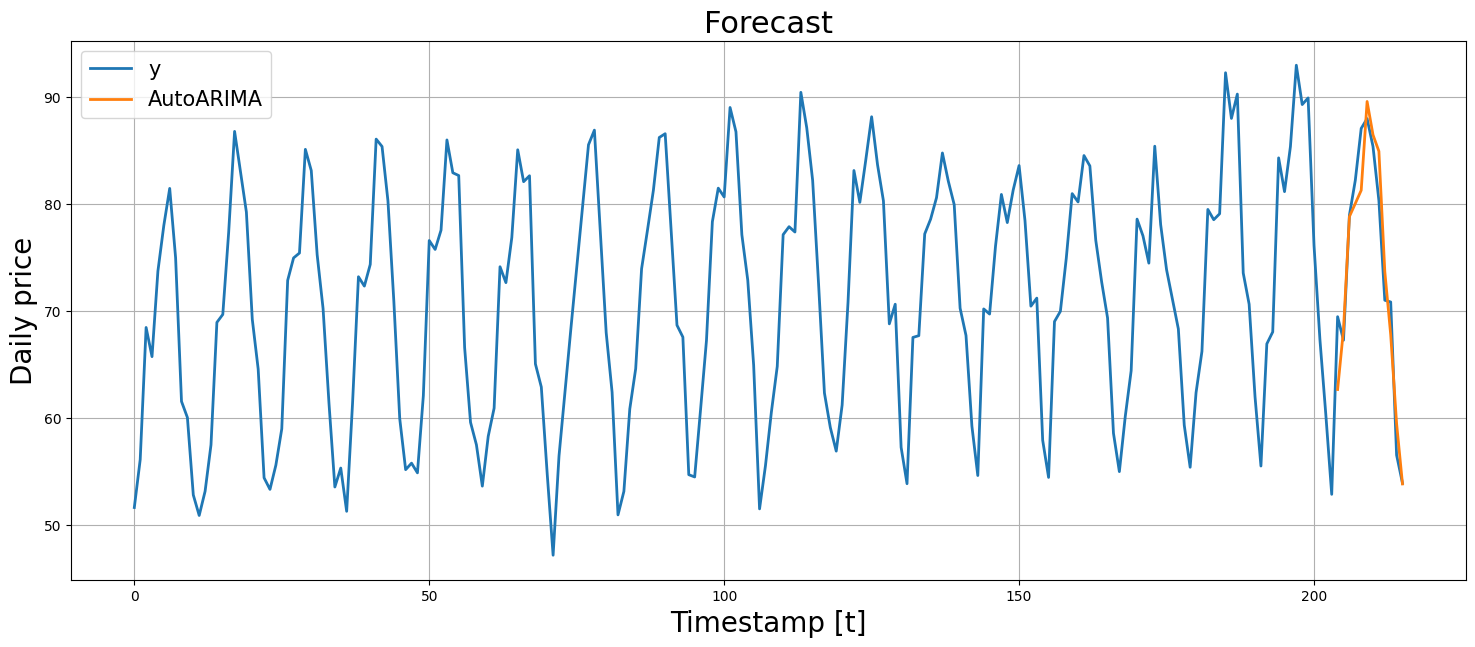

In [72]:
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize=(18, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title('Forecast', fontsize=22)
ax.set_ylabel('Daily price', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

plt.show()

In [76]:
%%capture
%pip install datasetsforecast


In [77]:
from datasetsforecast.losses import mae, mape, mase, rmse, smape
from sklearn.metrics import r2_score

def evaluate_performance(y_hist, y_true, model):
    evaluation = {}
    evaluation[model] = {}
    metrics = {
        'mase': mase,
        'mae': mae,
        'mape': mape,
        'rmse': rmse,
        'smape': smape,
        'r2_score': r2_score
    }

    for metric_name, metric_func in metrics.items():
        if metric_name == 'mase':
            evaluation[model][metric_name] = metric_func(y_true['y'].values,
                                                         y_true[model].values,
                                                         y_hist['y'].values,
                                                         seasonality=5)
        elif metric_name == 'r2_score':
            evaluation[model][metric_name] = metric_func(y_true['y'].values, y_true[model].values)
        else:
            evaluation[model][metric_name] = metric_func(y_true['y'].values, y_true[model].values)

    return pd.DataFrame(evaluation).T

evaluate_performance(Y_train_df, Y_hat_df, model='AutoARIMA')


,mae,mape,mase,r2_score,rmse,smape
AutoARIMA,2.666918,3.589271,0.150462,0.904402,3.370137,3.628245


In [79]:
sft = StatsForecast(df=df,
                   models=models,
                   freq=1,
                   n_jobs=-1)


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


In [82]:
sft.fit()
y_pred = sft.predict(h=12)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


In [86]:
df.tail()

,ds,unique_id,y
211,211,1,80.328
212,212,1,71.003
213,213,1,70.840
214,214,1,56.506
215,215,1,53.870


In [88]:
y_pred['AutoARIMA']

0     67.381126
1     65.739105
2     78.935913
3     80.310509
4     82.792328
5     87.938545
6     84.369293
7     80.773399
8     71.291924
9     70.302094
10    57.991890
11    54.506226
Name: AutoARIMA, dtype: float32

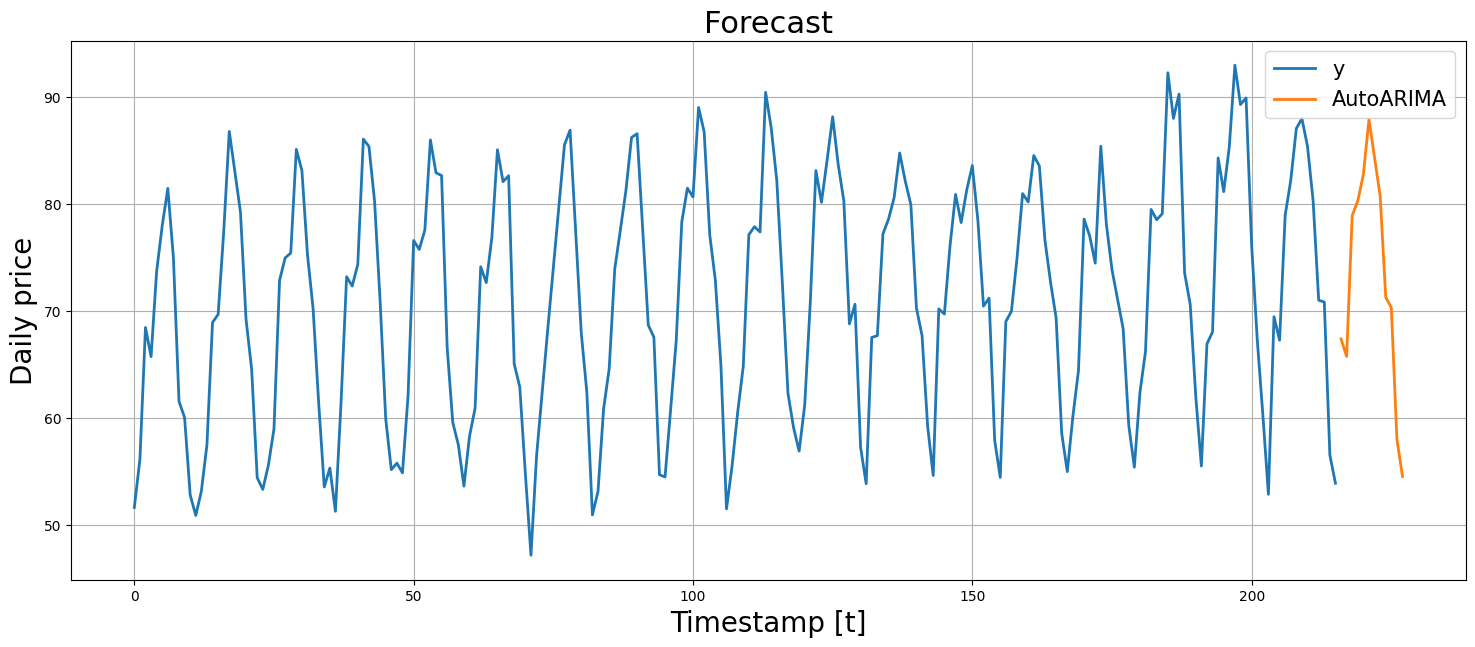

In [84]:
Y_hat_df = y_pred.merge(df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize=(18, 7))
plot_df = pd.concat([df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title('Forecast', fontsize=22)
ax.set_ylabel('Daily price', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

plt.show()